# 1. Library and device initialization

## 1.1 Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm


## 1.2 Device/GPU setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Setting up Data

## 2.1 Setting file paths

In [3]:
# adjusting file paths for Google Colab

def in_colab():
    try:
        from google.colab import drive
        return True
    except ImportError:
        return False

if in_colab():
    drive.mount('/content/drive')
    google_drive_path = '/content/drive/MyDrive/CS415/termproject/'
else:
    google_drive_path = ''


train_csv_path = google_drive_path + 'siim-acr-pneumothorax/stage_1_train_images.csv'
test_csv_path = google_drive_path + 'siim-acr-pneumothorax/stage_1_test_images.csv'
images_dir = google_drive_path + 'siim-acr-pneumothorax/png_images'
masks_dir = google_drive_path + 'siim-acr-pneumothorax/png_masks'


## 2.2 Creating the dataset class


In [4]:
class PneumoDataset(Dataset):
    """
    csv_path:
        The path to the csv file. Can direct to the traiA.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),n or test csv file depending on which dataset to use.
    image_dir:
        

    """
    def __init__(self, csv_path, images_dir, masks_dir, transform=None, mask_transform=None):
        self.df = pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx]['new_filename']

        img_path = os.path.join(self.images_dir, filename)
        mask_path = os.path.join(self.masks_dir, filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = torch.tensor(np.array(mask), dtype=torch.long)

        mask = (mask > 0).long()

        return image, mask, filename


## 2.3 Instantiating the dataset class objects and the loaders

In [ ]:


# --- transforms ---
image_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])   # optional but recommended
])

mask_transform = T.Compose([
    T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor()
])


# --- load datasets ---
full_train_dataset = PneumoDataset(
    csv_path=train_csv_path,
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=image_transform,
    mask_transform=mask_transform
)

# --- train/val split ---
val_ratio = 0.2  # 20% of train as validation
train_size = int((1.0 - val_ratio) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# print dataset sizes (train/val)
print(f"Train samples: {len(train_dataset)}")
print(f"Val   samples: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False
)

# --- test dataset and loader ---
test_dataset = PneumoDataset(
    csv_path=test_csv_path,
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=image_transform,
    mask_transform=mask_transform
)

# print test dataset size
print(f"Test  samples: {len(test_dataset)}")

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False
)




Train samples: 8540
Val   samples: 2135
Test  samples: 1372


## 2.4 Visualisation: plotting some samples from the train set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.4666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


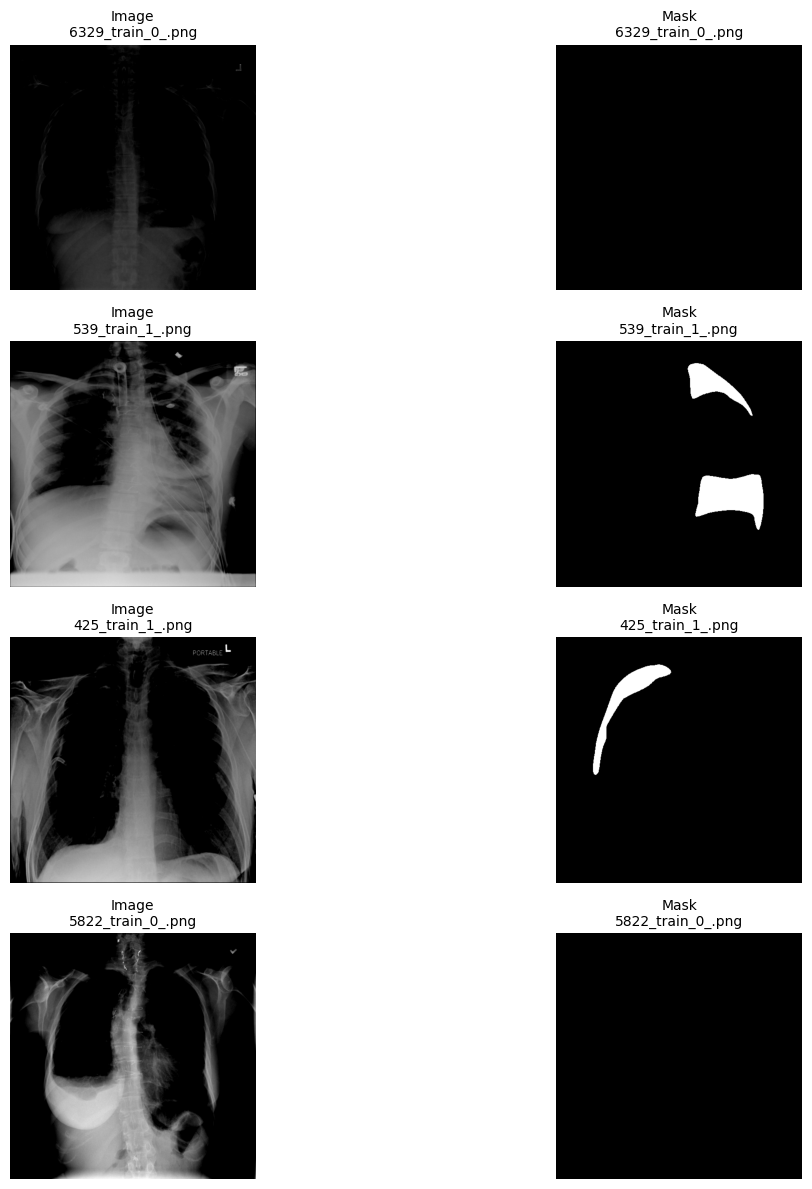

In [6]:
def show_batch(images, masks, filenames, num_samples=4):
    plt.figure(figsize=(14, num_samples * 3))
    
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].squeeze().numpy()
        name = filenames[i]

        # IMAGE
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Image\n{name}", fontsize=10)
        plt.axis("off")

        # MASK
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask\n{name}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


images, masks, filenames = next(iter(train_loader))


show_batch(images, masks, filenames, num_samples=4)



# 3. Model Construction

## 3.1 Building the U-NET model

In [7]:

class DoubleConv(nn.Module):
    """(conv → BN → ReLU) × 2"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),  # Only after second conv, lower rate
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, n_classes=1, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        in_ch = in_channels
        for feature in features:
            self.downs.append(DoubleConv(in_ch, feature))
            in_ch = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Down path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections for U-shape linking
        skip_connections = skip_connections[::-1]

        # Up path
        for idx in range(0, len(self.ups), 2):
            upsample = self.ups[idx]
            conv = self.ups[idx + 1]

            x = upsample(x)
            skip = skip_connections[idx // 2]

            # Padding in case shapes mismatch by 1 pixel
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = conv(x)

        return self.final_conv(x)

## 3.2 Istantiating the Model

In [8]:

model = UNet(
    in_channels=3,   # RGB X-ray images
    n_classes=1      # binary mask output
).to(device)

# Count and print the number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTrainable parameters: {num_params:,}")


Trainable parameters: 31,043,521


# 4. Training

## 4.1 Loss Function & Optimizer

In [9]:
def dice_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * intersection + smooth) / (union + smooth)

    return dice.mean()


criterion_bce = nn.BCEWithLogitsLoss()

def segmentation_loss(pred, mask):
    return criterion_bce(pred, mask.float()) + (1 - dice_score(pred, mask))



# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# learning rate scheduler - more aggressive settings
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=2)

## 4.2 Training functions

In [10]:
def train_one_epoch(model, dataloader, optimizer, device, epoch, num_epochs, log_interval=10):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)

    progress = tqdm(enumerate(dataloader), total=num_batches, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for batch_idx, (images, masks, _) in progress:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = segmentation_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_dice = dice_score(outputs, masks).item()

        running_loss += batch_loss * images.size(0)
        running_dice += batch_dice * images.size(0)

        if (batch_idx + 1) % log_interval == 0:
            progress.set_postfix({
                "batch_loss": f"{batch_loss:.4f}",
                "batch_dice": f"{batch_dice:.4f}"
            })

    epoch_loss = running_loss / num_samples
    epoch_dice = running_dice / num_samples

    return epoch_loss, epoch_dice


def evaluate(model, dataloader, device, split_name="Val"):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0

    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)

    progress = tqdm(enumerate(dataloader), total=num_batches, desc=f"[{split_name}]", leave=False)

    with torch.no_grad():
        for batch_idx, (images, masks, _) in progress:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = segmentation_loss(outputs, masks)

            batch_loss = loss.item()
            batch_dice = dice_score(outputs, masks).item()

            running_loss += batch_loss * images.size(0)
            running_dice += batch_dice * images.size(0)

            progress.set_postfix({
                "batch_loss": f"{batch_loss:.4f}",
                "batch_dice": f"{batch_dice:.4f}"
            })

    epoch_loss = running_loss / num_samples
    epoch_dice = running_dice / num_samples

    return epoch_loss, epoch_dice


## 4.3 Training Loop

In [11]:
num_epochs = 20
patience = 5          # early stopping patience
best_val_dice = 0.0
epochs_no_improve = 0

train_losses = []
val_losses = []
train_dices = []
val_dices = []

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # ---- training ----
    train_loss, train_dice = train_one_epoch(
        model, train_loader, optimizer, device,
        epoch=epoch, num_epochs=num_epochs
    )

    # ---- validation ----
    val_loss, val_dice = evaluate(
        model, val_loader, device,
        split_name="Val"
    )

    # ---- store metrics ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)

    print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Dice: {val_dice:.4f}")

    # ---- learning rate scheduler step ----
    scheduler.step(val_dice)

    # ---- save best model ----
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_unet.pth")
        print(f"→ New best model saved! (Val Dice = {best_val_dice:.4f})")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    # ---- early stopping ----
    if epochs_no_improve >= patience:

        print("Early stopping triggered.")
        break


===== Epoch 1/20 =====


Epoch 1/20 [Train]:   0%|          | 0/1068 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 7.62 GiB of which 44.69 MiB is free. Including non-PyTorch memory, this process has 7.14 GiB memory in use. Of the allocated memory 6.89 GiB is allocated by PyTorch, and 139.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 4.4 Visualization: Training Curves

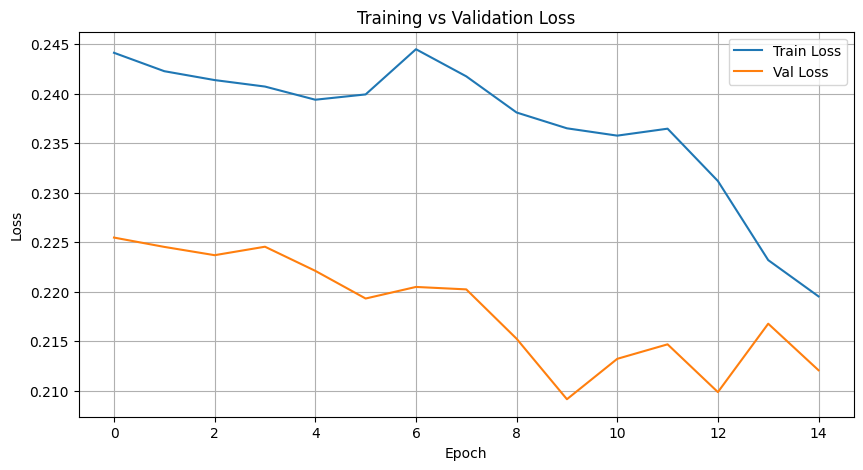

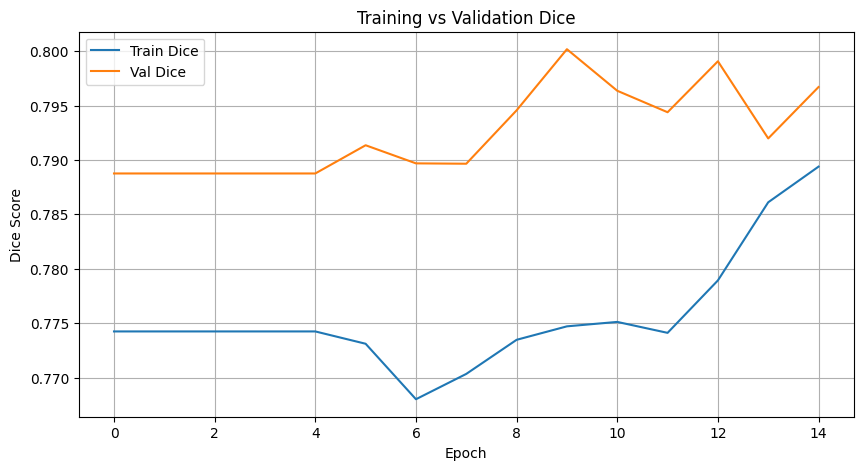

In [ ]:
# Loss Curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Dice Curves
plt.figure(figsize=(10,5))
plt.plot(train_dices, label="Train Dice")
plt.plot(val_dices, label="Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Training vs Validation Dice")
plt.legend()
plt.grid(True)
plt.show()


## 4.5 Test Model on Test Set

In [ ]:
model.load_state_dict(torch.load("best_unet.pth"))
test_loss, test_dice = evaluate(model, test_loader, device, split_name="Test")
print(f"\nFinal Test Loss: {test_loss:.4f} | Test Dice: {test_dice:.4f}")


[Test]:   0%|          | 0/172 [00:00<?, ?it/s]


Final Test Loss: 0.2175 | Test Dice: 0.7934
